# DDoS Network Intrusion Detection and Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

In [3]:
pwd

'/Users/karlamuller/my_notebooks'

In [4]:
# This extension for sound notification and cell completion time
get_ipython().magic('load_ext cellevents')

In [5]:
# Loading data for MSSQL, LDAP, NetBIOS, Syn and UDP attacks 
df_mssql = pd.read_csv('mydata/01-12/DrDoS_MSSQL.csv')
df_ldap = pd.read_csv('mydata/01-12/DrDoS_LDAP.csv')
df_netbios = pd.read_csv('mydata/01-12/DrDoS_NetBIOS.csv')
df_syn = pd.read_csv('mydata/01-12/Syn.csv')
df_udp = pd.read_csv('mydata/01-12/DrDoS_UDP.csv')

time: 2min 23s


## Creating main dataframe with all attacks

In [6]:
# Checking for class inbalance
print(df_mssql[' Label'].value_counts())
print(df_ldap[' Label'].value_counts())
print(df_netbios[' Label'].value_counts())
print(df_syn[' Label'].value_counts())
print(df_udp[' Label'].value_counts())

DrDoS_MSSQL    4522492
BENIGN            2006
Name:  Label, dtype: int64
DrDoS_LDAP    2179930
BENIGN           1612
Name:  Label, dtype: int64
DrDoS_NetBIOS    4093279
BENIGN              1707
Name:  Label, dtype: int64
Syn       1582289
BENIGN        392
Name:  Label, dtype: int64
DrDoS_UDP    3134645
BENIGN          2157
Name:  Label, dtype: int64
time: 1.34 s


In [8]:
# Due to high imbalance, creating a dataframe for benign connections
good_frames = [df_mssql[df_mssql[' Label'] == 'BENIGN'], 
          df_syn[df_syn[' Label'] == 'BENIGN'],
          df_netbios[df_netbios[' Label'] == 'BENIGN'],
          df_ldap[df_ldap[' Label'] == 'BENIGN'],
          df_udp[df_udp[' Label'] == 'BENIGN']]

df_benign = pd.concat(good_frames)

time: 1.38 s


In [ ]:
df_benign.shape

In [ ]:
# Subsampling 20% of the datasets with attacks only
df_mssql = pd.DataFrame.sample(
        df_mssql[df_mssql[' Label'] == 'DrDoS_MSSQL'], frac=0.2, replace=True )


df_ldap = pd.DataFrame.sample(
        df_ldap[df_ldap[' Label'] == 'DrDoS_LDAP'], frac=0.2, replace=True )

df_netbios = pd.DataFrame.sample(
        df_netbios[df_netbios[' Label'] == 'DrDoS_NetBIOS'], frac=0.2, replace=True )


df_syn =  pd.DataFrame.sample(
        df_syn[df_syn[' Label'] == 'Syn'], frac=0.2, replace=True )

df_udp = pd.DataFrame.sample(
        df_udp[df_udp[' Label'] == 'DrDoS_UDP'], frac=0.2, replace=True )

In [ ]:
# Joining all datasets  and shuffling them
dfList = [df_mssql, df_ldap, df_netbios, df_syn, df_udp, df_benign]
all_df = pd.concat(dfList,ignore_index=True)
all_df = all_df.sample(frac=1)

In [ ]:
# Creating an all df for easy future loads
all_df.to_csv('/Users/karlamuller/my_notebooks/mydata/all_df2.csv')

In [ ]:
pwd

In [40]:
all_df = pd.read_csv('mydata/all_df2.csv')

### EDA

In [4]:
all_df.head(2)

,Unnamed: 0,Unnamed: 0.1,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,2141543,7652,172.16.0.5-192.168.50.1-47827-47090-17,172.16.0.5,47827,192.168.50.1,47090,17,2018-12-01 13:04:42.030242,981829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP
1,1833555,16041,172.16.0.5-192.168.50.1-50388-43249-17,172.16.0.5,50388,192.168.50.1,43249,17,2018-12-01 12:59:00.749867,218355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [5]:
all_df.shape

(2386803, 89)

In [6]:
# Classification labels for dependent variable 
all_df[' Label'].unique()

array(['DrDoS_UDP', 'DrDoS_LDAP', 'DrDoS_NetBIOS', 'DrDoS_MSSQL', 'Syn',
       'BENIGN'], dtype=object)

In [42]:
# Assigning numeric values for classification variable 
all_df = all_df.replace({' Label': {'DrDoS_MSSQL':1, 'DrDoS_LDAP':2, 'DrDoS_NetBIOS':3, 'Syn':4,
       'DrDoS_UDP':5, 'BENIGN':0}})

In [43]:
# Converting to type int
all_df[' Label'].astype(int)
pd.set_option('display.min_rows', None)

In [44]:
# Verifying conversion
all_df[' Label'].unique()

array([5, 2, 3, 1, 4, 0])

In [45]:
# Checking unbalanced data
all_df[' Label'].value_counts()

3    818656
5    626929
2    435986
4    316458
1    180900
0      7874
Name:  Label, dtype: int64

In [46]:
# Finding datatypes
pd.set_option('display.max_rows', None)
all_df.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
Flow ID                          object
 Source IP                       object
 Source Port                      int64
 Destination IP                  object
 Destination Port                 int64
 Protocol                         int64
 Timestamp                       object
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets     float64
 Total Length of Bwd Packets    float64
 Fwd Packet Length Max          float64
 Fwd Packet Length Min          float64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max           float64
 Bwd Packet Length Min          float64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                     object
 Flow Packets/s                  object
 Flow IAT Mean                  float64


In [48]:
# Dropping non numeric identifiers 
all_df = all_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Flow ID', ' Source IP', ' Timestamp',
       ' Destination IP', 'SimillarHTTP'])

In [49]:
all_df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
count,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,...,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06,2.386803e+06
mean,2.097175e+04,3.284794e+04,1.551491e+01,1.123978e+06,3.182320e+00,5.785270e-02,1.145349e+03,7.080009e+00,4.934489e+02,4.854706e+02,...,4.793148e+02,6.569008e+02,1.577671e+03,1.592042e+02,2.177373e+05,7.166529e+04,3.225333e+05,1.465949e+05,9.969009e-01,3.313770e+00
std,2.346015e+04,1.891065e+04,3.761283e+00,1.028017e+07,2.222298e+02,1.153972e+00,1.146429e+03,1.458385e+03,4.875145e+02,4.894485e+02,...,3.945608e+04,4.423971e+04,8.560506e+04,2.562625e+04,2.117073e+06,7.992343e+05,3.123824e+06,1.536508e+06,5.558346e-02,1.265037e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.420000e+02,1.649200e+04,1.700000e+01,1.000000e+00,2.000000e+00,0.000000e+00,4.580000e+02,0.000000e+00,2.290000e+02,2.290000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
50%,9.950000e+02,3.285900e+04,1.700000e+01,1.000000e+00,2.000000e+00,0.000000e+00,7.500000e+02,0.000000e+00,3.690000e+02,3.210000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
75%,4.419200e+04,4.924900e+04,1.700000e+01,4.500000e+01,2.000000e+00,0.000000e+00,1.438000e+03,0.000000e+00,4.370000e+02,4.320000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00
max,6.553200e+04,6.553500e+04,1.700000e+01,1.199997e+08,8.617600e+04,8.170000e+02,6.931000e+04,1.468048e+06,3.547000e+03,1.472000e+03,...,3.844614e+07,4.868047e+07,7.286843e+07,1.310114e+07,1.166865e+08,5.424436e+07,1.166865e+08,1.166865e+08,1.000000e+00,5.000000e+00


In [50]:
# Converting flow packets to float (was object)
all_df[' Flow Packets/s']= all_df[' Flow Packets/s'].astype(float)
# Converting flow bytes to float (was object)
all_df['Flow Bytes/s']= all_df['Flow Bytes/s'].astype(float)

In [51]:
# Maximum value 
all_df[' Flow Packets/s'].max()

inf

In [52]:
# Number of infinity values 
all_df[' Flow Packets/s'].loc[all_df[' Flow Packets/s'] == np.inf].count()

87146

In [53]:
# Maximum value 
all_df['Flow Bytes/s'].max()

inf

In [54]:
# Number of infinity values 
all_df['Flow Bytes/s'].loc[all_df['Flow Bytes/s'] == np.inf].count()

46848

In [55]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

In [56]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40298

In [57]:
# Finding max value thats not infinity and assigning it to inf
max_bytes = all_df.loc[all_df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
all_df['Flow Bytes/s'].replace(np.inf,max_bytes,inplace=True)

In [58]:
# Finding max value thats not infinity and assigning it to inf
max_packets = all_df.loc[all_df[' Flow Packets/s'] != np.inf, ' Flow Packets/s'].max()
all_df[' Flow Packets/s'].replace(np.inf,max_packets,inplace=True)

In [59]:
# Finding nans
all_df[' Flow Packets/s'].isna().sum()

0

In [60]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

40298

In [61]:
# 'Flow Bytes/s' has all of dfs nans
pd.set_option('display.max_rows', None)
all_df.isna().sum()

 Source Port                        0
 Destination Port                   0
 Protocol                           0
 Flow Duration                      0
 Total Fwd Packets                  0
 Total Backward Packets             0
Total Length of Fwd Packets         0
 Total Length of Bwd Packets        0
 Fwd Packet Length Max              0
 Fwd Packet Length Min              0
 Fwd Packet Length Mean             0
 Fwd Packet Length Std              0
Bwd Packet Length Max               0
 Bwd Packet Length Min              0
 Bwd Packet Length Mean             0
 Bwd Packet Length Std              0
Flow Bytes/s                    40298
 Flow Packets/s                     0
 Flow IAT Mean                      0
 Flow IAT Std                       0
 Flow IAT Max                       0
 Flow IAT Min                       0
Fwd IAT Total                       0
 Fwd IAT Mean                       0
 Fwd IAT Std                        0
 Fwd IAT Max                        0
 Fwd IAT Min

In [62]:
# 'Flow Bytes/s' quick stats
all_df['Flow Bytes/s'].describe()

count    2.346505e+06
mean     7.623327e+08
std      9.627836e+08
min      0.000000e+00
25%      1.380144e+04
50%      4.580000e+08
75%      8.160000e+08
max      2.944000e+09
Name: Flow Bytes/s, dtype: float64

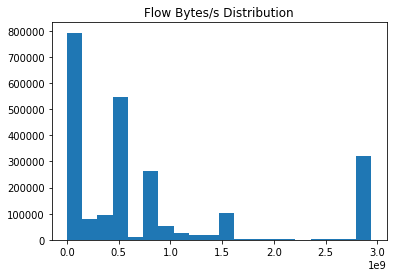

In [63]:
# 'Flow Bytes/s' distribution
plt.figure()
plt.hist(all_df['Flow Bytes/s'], bins=20)
plt.title('Flow Bytes/s Distribution')
plt.show()

In [64]:
# Which class has null values
g = all_df.groupby(' Label')
g = g.count().rsub(g.size(), axis=0)
g['Flow Bytes/s']

 Label
0       32
1        1
2        0
3        1
4    40264
5        0
Name: Flow Bytes/s, dtype: int64

In [65]:
# This takes a bit
# Filling nans with medians of each class
all_df['Flow Bytes/s'] = all_df.groupby(" Label").transform(lambda x: x.fillna(x.median()))

In [66]:
# Finding nans
all_df['Flow Bytes/s'].isna().sum()

0

In [67]:
all_df.isna().sum()

 Source Port                    0
 Destination Port               0
 Protocol                       0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean                   0
 Bwd IAT Std  

### Assigning variables for Lasso Regression

In [30]:
# Shuffling rows 
all_df = all_df.sample(frac=1)

In [31]:
# Defining my variables 
X = all_df.iloc[:,:-1]
y = all_df.iloc[:,-1]

In [73]:
# Applying Lasso regression
lasso_all_df = Lasso()
lasso_all_df.fit(X,y)

lasso_all_df.coef_

array([-6.00949837e-06,  6.23362650e-07, -0.00000000e+00,  7.53613434e-09,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  6.02315684e-05,
        2.90659399e-03, -0.00000000e+00,  0.00000000e+00,  2.15180036e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.80252354e-11, -1.65687549e-07, -4.67427189e-08,  2.66528428e-07,
        2.50860933e-08, -6.33715941e-06, -9.79107932e-09,  3.14267150e-07,
        2.59114996e-08, -2.25156720e-09,  5.95798213e-06, -3.44819218e-08,
        1.15966153e-07, -1.51259203e-07,  8.36694387e-08, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.76070902e-11,  1.35740280e-09, -1.14423952e-07, -4.07269867e-06,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.32282523e-05,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

time: 3min 10s


In [29]:
# Creating dataframe for lasso coeffs
a = [X.columns, lasso_all_df.coef_]
df_lasso = pd.DataFrame(a).T


NameError: name 'lasso_all_df' is not defined

time: 183 ms


In [47]:
# Renaming columns
df_lasso = df_lasso.rename(columns={0:'variables', 1:'coeff'})

NameError: name 'df_lasso' is not defined

time: 675 ms


In [82]:
# Sorting 
df_lasso.sort_values(by='coeff', ascending=False)

,variables,coeff
11,Fwd Packet Length Std,0.021518
55,Avg Fwd Segment Size,0.00416213
8,Fwd Packet Length Max,0.00290659
65,Subflow Fwd Bytes,0.00017586
68,Init_Win_bytes_forward,0.000144261
7,Total Length of Bwd Packets,6.02316e-05
26,Fwd IAT Min,5.95798e-06
1,Destination Port,6.23363e-07
23,Fwd IAT Mean,3.14267e-07
19,Flow IAT Std,2.66528e-07


time: 20.1 ms


In [83]:
# Assignig zero coefficients 
zero_coeffs = df_lasso[df_lasso.coeff == 0]

time: 8.06 ms


In [84]:
zero_coeffs['variables'].values

array([' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', 'FIN Flag Count', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       ' Down/Up Ratio', ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       ' act_data_pkt_fwd', ' Active Std', ' Inbound'], dtype=object)

time: 2.97 ms


In [68]:
# Dropping variables with zero coefficient
all_df = all_df.drop(columns=[' Protocol', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', 'FIN Flag Count', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       ' Down/Up Ratio', ' Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
       ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       ' act_data_pkt_fwd', ' Active Std', ' Inbound'])

In [33]:
all_df.shape

(2386803, 42)

In [92]:
# Finding top coefficients 
df_lasso = df_lasso.sort_values(by="coeff_abs", ascending=False)
df_lasso.head(5)

,variables,coeff,coeff_abs
11,Fwd Packet Length Std,0.021518,0.021518
54,Average Packet Size,-0.00570521,0.00570521
55,Avg Fwd Segment Size,0.00416213,0.00416213
8,Fwd Packet Length Max,0.00290659,0.00290659
69,Init_Win_bytes_backward,-0.000218227,0.000218227


time: 8.97 ms


In [19]:
from collections import Counter
# Counting y
Counter(y_train)

Counter({1: 723606, 3: 654930, 5: 501542, 2: 348773, 4: 220841, 0: 1262})

In [70]:
# Generating a csv file for easy access to cleaned data
all_df.to_csv('/Users/karlamuller/my_notebooks/mydata/all_dfclean.csv')

In [71]:
all_df.head()

,Source Port,Destination Port,Flow Duration,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,47827,47090,981829,0.0,401.0,30.127623,47827.0,2.037015e+01,51675.210526,55996.987620,...,-1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,50388,43249,218355,0.0,393.0,35.088460,50388.0,2.747819e+01,43671.000000,59800.359932,...,-1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,598,23283,2,0.0,1472.0,0.000000,598.0,1.000000e+06,2.000000,0.000000,...,-1,1473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,664,25980,1,0.0,1472.0,0.000000,664.0,2.000000e+06,1.000000,0.000000,...,-1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,574,13836,1,0.0,229.0,0.000000,574.0,2.000000e+06,1.000000,0.000000,...,-1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
